In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')
data_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')
pseudo_labels_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/pseudo_submission.csv')

data_test_labeled = data_test.copy()
data_test_labeled['Survived'] = pseudo_labels_test['Survived']

all_data = pd.concat([data_train, data_test_labeled]).reset_index(drop=True)

In [7]:
def label_encoder(column):
    lc = LabelEncoder()
    return lc.fit_transform(column)

In [8]:
def titanic_preprocessing(df):
    age = df[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    df['Age'] = df['Age'].fillna(df['Pclass'].map(age['Age']))

    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Ticket
    df['Ticket'] = df['Ticket'].fillna('X').map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # Cabin
    df['Cabin'] = df['Cabin'].fillna('X').map(lambda x: x[0].strip()) 

    df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

    return df

In [9]:
def titanic_feature_engineering(df):
    # Create dummy variables
    dummy = pd.get_dummies(df[['Embarked', 'Cabin']], dtype=np.int32)
    df = pd.concat([df, dummy], axis=1)
    df.drop(['Embarked', 'Cabin'], axis=1, inplace=True)

    # Label Encoder
    ticket_labeled = df[['Ticket']].apply(label_encoder)
    ticket_labeled.columns = ['Ticket labeled']
    df = pd.concat([df, ticket_labeled], axis=1)
    df.drop(['Ticket'], axis=1, inplace=True)

    df['Sex_dummy'] = df['Sex'].map({'male': 0, 'female': 1})
    df.drop(['Sex'], axis=1, inplace=True)

    return df

In [10]:
def dataset_preparation(df):
    df = titanic_preprocessing(df)
    df = titanic_feature_engineering(df)
    return df

In [11]:
# data_train_copy = data_train.copy()
data_test_copy = data_test.copy()
all_data_copy = all_data.copy()

# data_train_prep = dataset_preparation(data_train_copy)
data_test_prep = dataset_preparation(data_test_copy)
all_data_prep = dataset_preparation(all_data_copy)

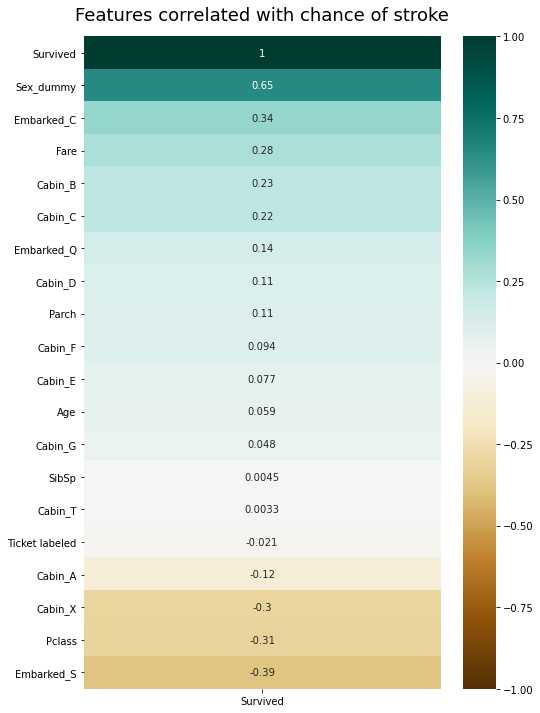

In [12]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(all_data_prep.corr()[['Survived']].sort_values(by='Survived', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features correlated with chance of stroke', fontdict={'fontsize': 18}, pad=16);

In [13]:
# Split data into train and validation sets
X = all_data_prep.drop(['Survived'], axis=1)
y = all_data_prep['Survived']

# Scalling
# scaler = StandardScaler()
# X[X.columns] = scaler.fit_transform(X[X.columns])
# data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # F1 score
    scores_f1 = cross_val_score(model, X, y, scoring = 'f1' ,cv=5)
    print('F1 scores: {}'.format(scores_f1))
    print('F1 mean score: {}'.format(scores_f1.mean()))

    # Accuracy score
    scores_acc = cross_val_score(model, X, y, cv=5)
    print('Acc scores: {}'.format(scores_acc))
    print('Acc mean score: {}'.format(scores_acc.mean()))
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')

<h1> Light Gradient Boost Classifier </h1>

In [15]:
# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	trees = range(50, 150, 5)
# 	for n in trees:
# 		models[str(n)] = LGBMClassifier(n_estimators=n)
# 	return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# 	return scores

In [16]:
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

In [17]:
# fig = go.Figure()

# for num, result in enumerate(results):
#     fig.add_trace(go.Box(
#     y = result,
#     name=names[num]
#     ))

# fig.show()

In [18]:
# LightGBM
LGBM_model = LGBMClassifier(
    metric = 'binary_logloss',
    n_estimators = 1000,
    objective = 'binary',
    random_state = 42,
    learning_rate = 0.01,
    min_child_samples = 150,
    reg_alpha = 3e-5,
    reg_lambda = 9e-2,
    num_leaves = 20,
    max_depth = 16,
    colsample_bytree = 0.8,
    subsample = 0.8,
    subsample_freq = 2,
    max_bin = 240
)

# model_evaluation(LGBM_model)

In [19]:
# parameters = {
#     'num_leaves': range(25, 50, 1)
# }

# search = GridSearchCV(LGBM_model, parameters, verbose=3, scoring='f1')
# search.fit(X_train, y_train)

In [20]:
# print('Best Score for LGB: {} \nWith params: {}'.format(search.best_score_, search.best_params_))

In [21]:
LGBM_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
# y_pred = LGBM_model.predict(data_test_prep)
y_pred_proba_light = LGBM_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v4.csv', index=False)

id_0's binary_logloss: 0.295289
[1526]	valid_0's binary_logloss: 0.295285
[1527]	valid_0's binary_logloss: 0.295284
[1528]	valid_0's binary_logloss: 0.295283
[1529]	valid_0's binary_logloss: 0.295282
[1530]	valid_0's binary_logloss: 0.295277
[1531]	valid_0's binary_logloss: 0.295273
[1532]	valid_0's binary_logloss: 0.295272
[1533]	valid_0's binary_logloss: 0.295266
[1534]	valid_0's binary_logloss: 0.295265
[1535]	valid_0's binary_logloss: 0.295263
[1536]	valid_0's binary_logloss: 0.29526
[1537]	valid_0's binary_logloss: 0.295257
[1538]	valid_0's binary_logloss: 0.295255
[1539]	valid_0's binary_logloss: 0.295254
[1540]	valid_0's binary_logloss: 0.295249
[1541]	valid_0's binary_logloss: 0.295248
[1542]	valid_0's binary_logloss: 0.295246
[1543]	valid_0's binary_logloss: 0.295244
[1544]	valid_0's binary_logloss: 0.295241
[1545]	valid_0's binary_logloss: 0.295239
[1546]	valid_0's binary_logloss: 0.295239
[1547]	valid_0's binary_logloss: 0.295238
[1548]	valid_0's binary_logloss: 0.295237
[15

<h1> CatBoost </h1>

In [22]:
cat_model = CatBoostClassifier(
    silent=True,
    bootstrap_type = 'Poisson',
    loss_function = 'Logloss',
    eval_metric = 'Logloss',
    random_seed = 42,
    task_type = 'GPU',
    max_depth = 8,
    learning_rate = 0.01,
    n_estimators = 1000,
    max_bin = 280,
    min_data_in_leaf = 64,
    l2_leaf_reg = 0.01,
    subsample = 0.8
)

# model_evaluation(cat_model)

In [23]:
cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
# y_pred_cat = cat_model.predict(data_test_prep)
y_pred_proba_cat = cat_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v5.csv', index=False)

<h1> Decision Tree Model </h1>

In [24]:
tree_model = DecisionTreeClassifier(
    random_state = 42,
    max_depth = 4,
    min_samples_leaf = 2
)

In [25]:
tree_model.fit(X_train, y_train)
# y_pred_tree = tree_model.predict(data_test_prep)
y_pred_proba_tree = tree_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v5.csv', index=False)

In [26]:
# estimators = [
#     ('LGBM', LGBM_model),
#     ('Tree', tree_model)
# ]

# super_model = StackingClassifier(estimators=estimators, final_estimator=cat_model)

In [27]:
# model_evaluation(super_model)

In [28]:
# super_model.fit(X, y)
# y_pred = super_model.predict(data_test_prep)
# # y_pred_proba = super_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v7.csv', index=False)

In [29]:
submissions = pd.DataFrame()
submissions['submit_lgb'] = np.where(y_pred_proba_light[:, 1] > 0.5, 1, 0)
submissions['submit_cat'] = np.where(y_pred_proba_cat[:, 1] > 0.5, 1, 0)
submissions['submit_tree'] = np.where(y_pred_proba_tree[:, 1] > 0.5, 1, 0)

In [30]:
submissions.head(100)

,submit_lgb,submit_cat,submit_tree
0,0,0,0
1,1,1,1
2,1,1,1
3,0,0,0
4,1,1,1
...,...,...,...
95,0,0,0
96,0,0,0
97,1,1,1
98,0,0,0


In [31]:
submissions[[col for col in submissions.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    65680
3    31086
1     2539
2      695
dtype: int64

In [32]:
submissions['Survived'] = (submissions[[col for col in submissions.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submissions

,submit_lgb,submit_cat,submit_tree,Survived
0,0,0,0,0
1,1,1,1,1
2,1,1,1,1
3,0,0,0,0
4,1,1,1,1
...,...,...,...,...
99995,1,1,1,1
99996,0,0,0,0
99997,0,0,0,0
99998,1,1,1,1


In [33]:
my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': submissions['Survived']})
my_submission.to_csv('submission_v9.csv', index=False)